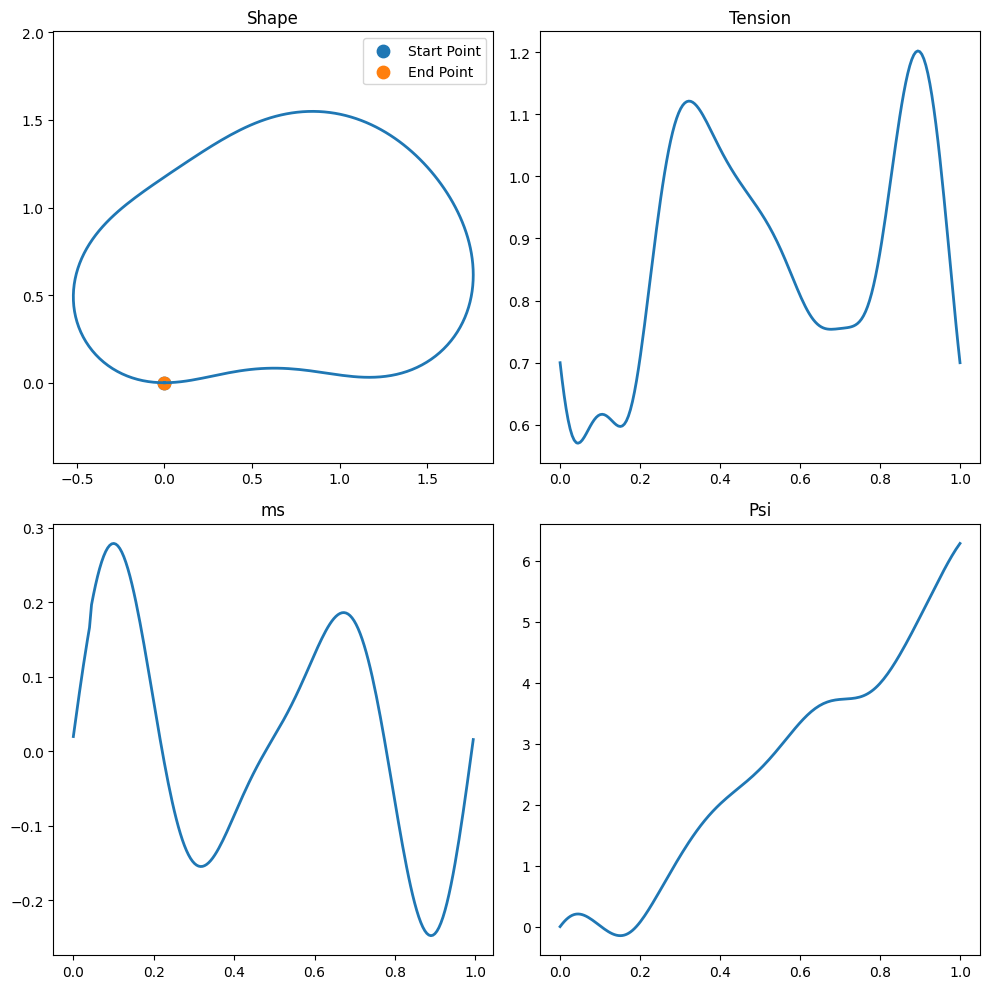

Length: 6.183272076637176
integrals: (np.float64(0.10557520758843086), np.float64(-0.024195173440836104), np.float64(0.0980082077493416))


201

In [5]:
#forward solution
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
import scipy.integrate as sint

def gen_tns(pn, a=0.5, b=0.8, option='alex'):
    if option == 'alex':
        tns = lambda x: a * ( np.cos(pn*np.pi*x+np.pi)**2 - 0.5 ) + b * ( np.cos(2*np.pi*(x-1.5)+np.pi)**2 - 0.5 )
        dtn = lambda x: a * ( -(pn*np.pi)*2*np.cos(pn*np.pi*x+np.pi)*np.sin(pn*np.pi*x+np.pi)) - b * (2*np.pi)*2*np.cos(2*np.pi*(x-1.5)+np.pi)*np.sin(2*np.pi*(x-1.5)+np.pi)
        return tns, dtn
    elif option == 'santi':
        mag = 1
        rel_asymm_mag = 0.3

        NrModes = 1  # How many Fourier modes should be included
        Nmax = 5  # Maximal mode number to draw from (Nmax >= NrModes)
        N = np.random.choice(range(2, 3), NrModes, replace=False)  # Set of modes
        Magnc = mag * (np.random.rand(NrModes) - 0.5)  # Magnitudes of cosine modes
        Magns = mag * (np.random.rand(NrModes) - 0.5)  # Magnitudes of sine modes

        tns_symm = lambda x: (np.real(np.exp(1j * 2 * np.pi * x[:, None] * N) @ Magnc) +
                        np.imag(np.exp(1j * 2 * np.pi * x[:, None] * N) @ Magns))

        tns_asymm = lambda x: rel_asymm_mag * (np.real(np.exp(1j * 2 * np.pi * x[:, None] * N* 1.5 + 2 * np.pi / 7) @ Magnc) +
                        np.imag(np.exp(1j * 2 * np.pi * x[:, None] * N*1.5 + 2 * np.pi * 0.1) @ Magns))

        tns = lambda x: tns_symm(x) + tns_asymm(x)

N1 = 200
tns, dtn = gen_tns(3, a=0.5, b=0.80, option='alex')
# tns = None
# dtn = None
sol = forward_solver(N1, tns=tns, dtns=dtn, mag=0.6, tol=1e-4)
curve = sol[2:4].T
psis_actual = sol[0]
tns_actual = sol[-1]
sigmas_actual = sol[1]

L = sol[4, 0]
intx, inty, intz = get_integral_shape(sol)
print(f'integrals: {intx, inty, intz}')
N1 = len(psis_actual)
N1

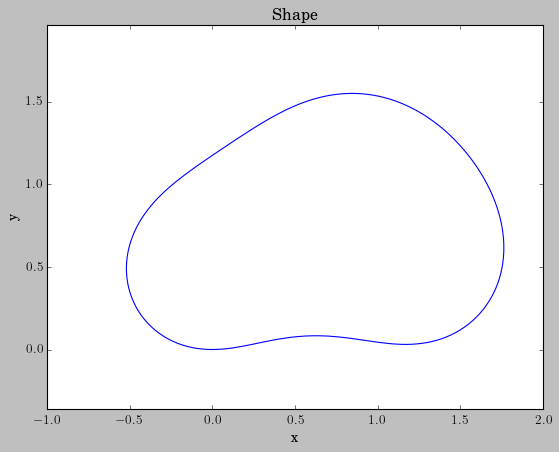

In [43]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

# Extract the first half of the curve
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'  # Set math font to Computer Modern (cm)

# Plot the first half of the curve
plt.plot(curve[:, 0], curve[:, 1])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')

plt.title('Shape')
plt.savefig('shape 1.pdf')
plt.show()

In [ ]:
sins = np.sin(psis_actual)
cosins = np.cos(psis_actual)
print(sint.trapezoid(sigmas_actual * sins, dx=L/(N1)))

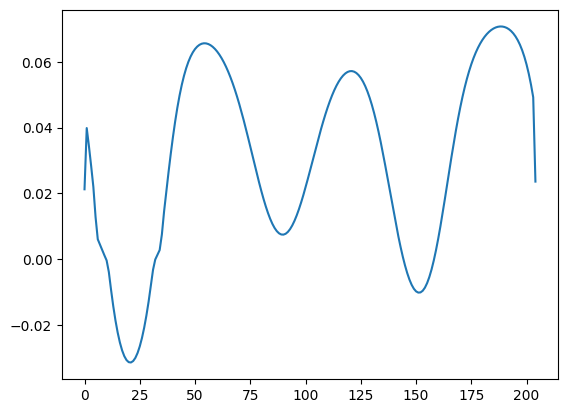

In [26]:
plt.plot(dps(psis_actual, L), label='actual')

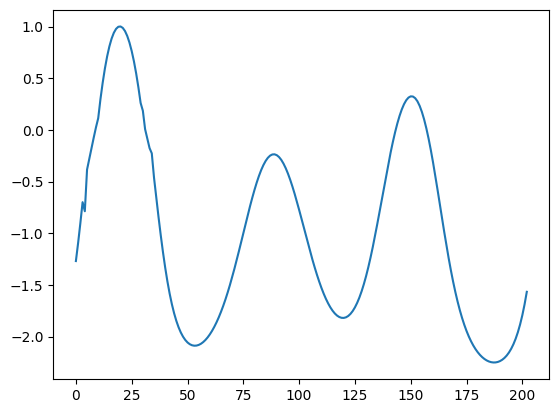

In [23]:
curv = [curvature(curve, i) for i in range(N1)]
plt.plot(curv[1:-1], label='curvature')

### eom diff for forward

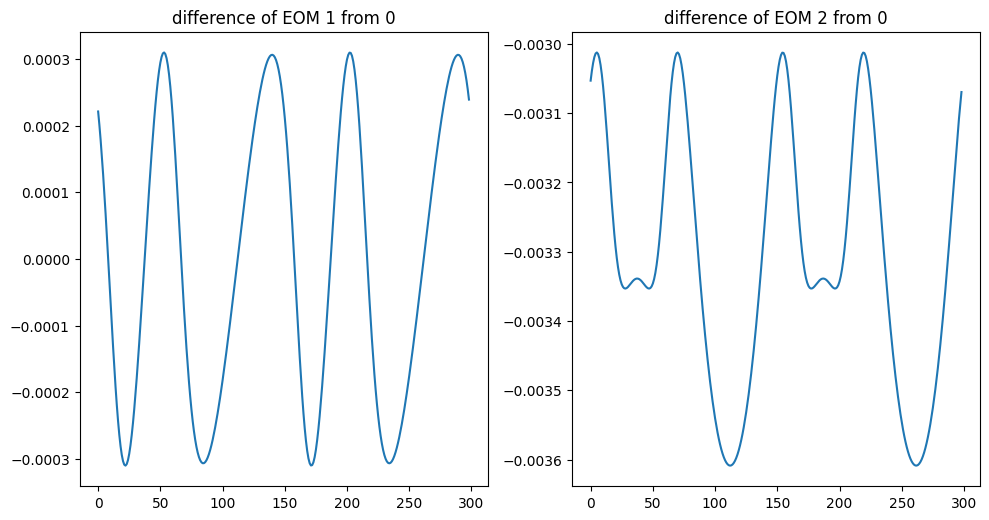

In [6]:
# EOM diff exact:
delta_s = L / len(psis_actual)
kappas_actual = dps(psis_actual[:-1], psis=True) / delta_s # :-1 because the fwd gives a closing curve which doesn't work with out periodic derivative
dtns = dps(tns_actual[:-1]) / delta_s
dsigma = dps(sigmas_actual[:-1]) / delta_s

d1 = dsigma + tns_actual[:-1] * kappas_actual
d2 = dtns - sigmas_actual[:-1] * kappas_actual + 1

plt.figure(figsize=(10, 10))

# Plot xs and ys
plt.subplot(2,2,1)
plt.plot(d1)
# plt.axis('equal')
plt.title('difference of EOM 1 from 0')

# Plot xs and ys
plt.subplot(2,2,2)
plt.plot(d2[:])
plt.title('difference of EOM 2 from 0')

plt.tight_layout()
plt.show()

### Trial noise removal: finnicky code

a surprise to be sure, but a welcome one


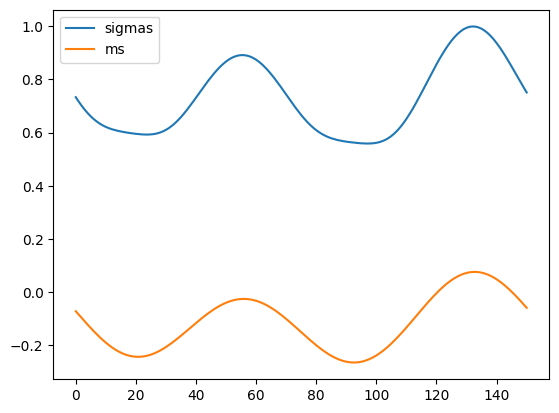

In [44]:
#backward inference
import matplotlib.pyplot as plt
from helper_functions import *

N = N1

sigmas, ms = backward_solver_cont(curve, L, N, prec=1e-5)
sigmas, ms = backward_solver_set(curve, L, N, prec=1e-7)

plt.plot(sigmas, label='sigmas')
plt.plot(ms, label='ms')
plt.legend()
plt.show()

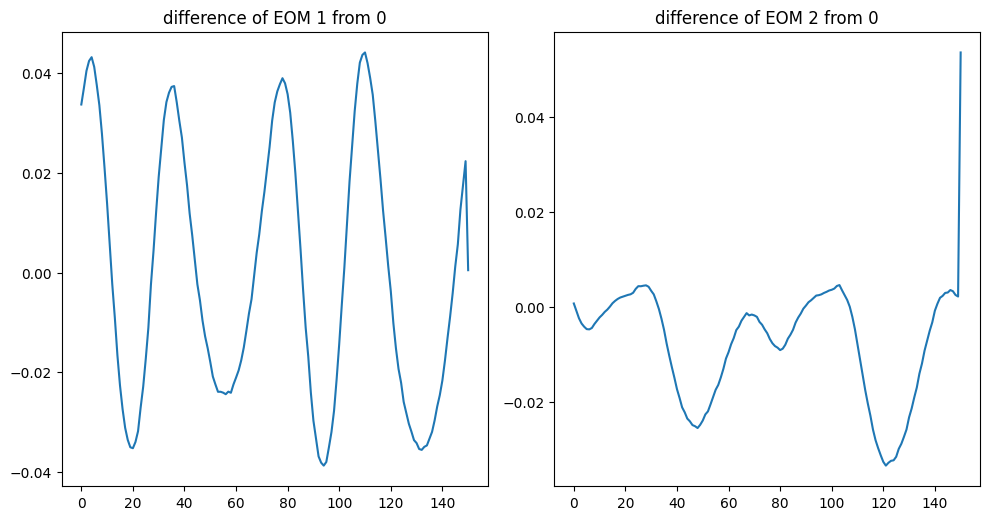

In [45]:
#now get EOM diff
delta_s = L / N1

kappas_actual = dps(psis_actual[:-1], psis=True) / delta_s # :-1 because the fwd gives a closing curve which doesn't work with out periodic derivative
kappas_actual[-1] = kappas_actual[0]
kappas_actual = interpolate_seq_periodic(kappas_actual)(np.linspace(0, 1, N))

delta_s = L / N

tns = -dps(ms) / delta_s
dtns = dps(tns) / delta_s
dsigma = dps(sigmas) / delta_s

d1 = dsigma + tns * kappas_actual
d2 = dtns - sigmas * kappas_actual + 1

plt.figure(figsize=(10, 10))

# Plot xs and ys
plt.subplot(2,2,1)
plt.plot(d1)
# plt.axis('equal')
plt.title('difference of EOM 1 from 0')

# Plot xs and ys
plt.subplot(2,2,2)
plt.plot(d2[:])
plt.title('difference of EOM 2 from 0')

plt.tight_layout()
plt.show()

# plt.plot(kappas_actual)



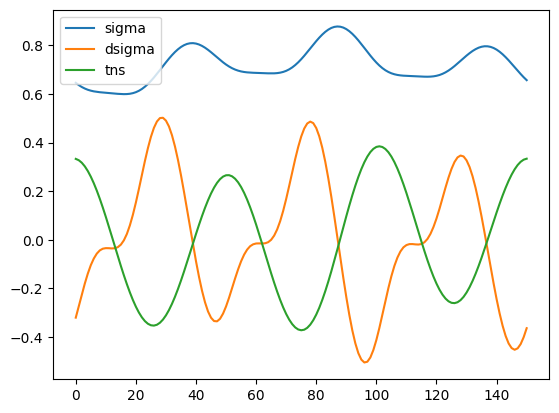

In [59]:
plt.plot(sigmas, label='sigma')
plt.plot(dsigma, label='dsigma')
plt.plot(tns * (2 * np.pi / L), label='tns')
plt.legend()
plt.show()

In [60]:
cos_psis = np.cos(psis_actual)
sin_psis = np.sin(psis_actual)

a1 = 2 * sint.trapezoid(sin_psis * sigmas, dx=L/len(curve))
a2 = 2 * sint.trapezoid(cos_psis * dsigma, dx=L/len(curve))

print((a1 / a2) * 2 * np.pi, ' (this should be about L)')

-78.36362137263778  (this should be about L)


### nicer code

a surprise to be sure, but a welcome one


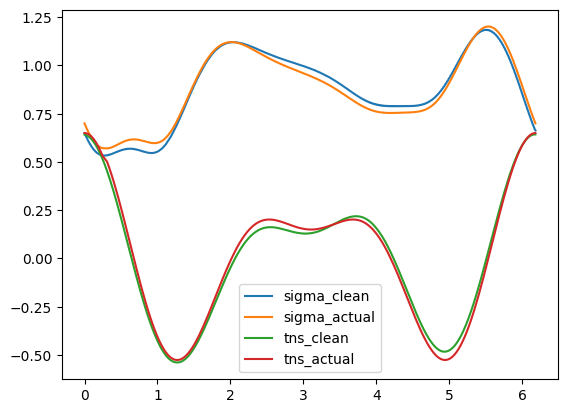

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

def backward_solver_set_clean(curve, L, N, ints, clean_N=1e4, cont=False, prec=1e-7):
    intx, inty, intz = ints

    if cont:
        sigmas, ms = backward_solver_cont(curve, L, N, prec=prec)
    else:
        sigmas, ms = backward_solver_set(curve, L, N, prec=prec)

    delta_s = L / N
    tns = -dps(ms) / delta_s

    psis = get_tgt_angles(curve)
    psis = interp1d(np.linspace(0, 1, len(curve)), psis)(np.linspace(0, 1, N))
    kappas = dps(psis, psis=True) / delta_s

    cos_psis = np.cos(psis)
    sin_psis = np.sin(psis)

    a1 = sint.trapezoid(cos_psis * sigmas * kappas, dx= L/N) / np.pi
    a2 = sint.trapezoid(sin_psis * sigmas*kappas, dx= L/N)/ np.pi
    a3 = sint.trapezoid(cos_psis * tns*kappas, dx= L/N)/ np.pi
    a4 = sint.trapezoid(sin_psis * tns*kappas, dx= L/N)/ np.pi

    intx, inty, intz = ints
    intx /= L
    inty /= L
    intz /= L    
    sigmas_clean = sigmas - a1 * cos_psis - a2 * sin_psis
    tns_clean = tns - a3* cos_psis - a4 * sin_psis

    sigmas_a_bit_dirty = sigmas_clean + (intx * np.cos(psis) + inty * np.sin(psis))
    tns_a_bit_dirty = tns_clean + (intx * np.sin(psis) - inty * np.cos(psis))

    #fix if needed:
    hom1 = a1 * cos_psis + a2 * sin_psis
    hom2 = a3 * cos_psis + a4 * sin_psis
    
    return sigmas_a_bit_dirty, ms, tns_a_bit_dirty, kappas, hom1, hom2, psis

N = 501
ints = get_integral_shape(sol)
sigmas_a_bit_dirty, ms, tns_a_bit_dirty, kappas, hom1, hom2, psis = backward_solver_set_clean(curve, L, N, ints, cont=False, prec=1e-7)
ms_clean = sint.cumulative_trapezoid(tns_a_bit_dirty, dx=L/N)
# sigmas_clean, tns_clean = sigmas_clean[50:80], tns_clean[50:80]
# sigmas_actual, tns_actual = sigmas_actual[50:80], tns_actual[50:80]

plt.plot(np.linspace(0, L, len(sigmas_a_bit_dirty))[:], sigmas_a_bit_dirty[:], label='sigma_clean')
plt.plot(np.linspace(0, L, len(sigmas_actual)), sigmas_actual, label='sigma_actual')
plt.plot(np.linspace(0, L, len(sigmas_a_bit_dirty))[:], tns_a_bit_dirty[:], label='tns_clean')
plt.plot(np.linspace(0, L, len(sigmas_actual)), tns_actual, label='tns_actual')
plt.legend()
plt.show()

This is a really nice figure and it took 10 minutes to run so we wanna save it for the paper

Really we want to save the numpy arrays so that we can experiment with different plotting styles and so on,

But first we want to test out that cleaning theory real quick.

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/tw/wwds8prs35n99xx6b_5911sh0000gn/T/ipykernel_59270/296425455.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, 1, len(sigmas_a_bit_dirty)), sigmas_a_bit_dirty, label='inferred $\sigma$')
/var/folders/tw/wwds8prs35n99xx6b_5911sh0000gn/T/ipykernel_59270/296425455.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, 1, len(sigmas_actual)), sigmas_actual, label='true $\sigma$')


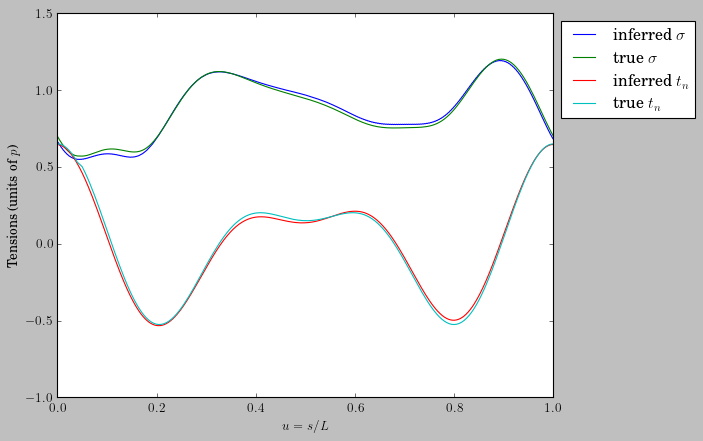

In [31]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'  # Set math font to Computer Modern (cm)


psis = get_tgt_angles(curve)
psis = interp1d(np.linspace(0, 1, len(curve)), psis)(np.linspace(0, 1, N))

intx, inty, intz = ints
intx /= L
inty /= L
intz /= L

sigmas_a_bit_dirty = sigmas_clean + (intx * np.cos(psis) + inty * np.sin(psis))
tns_a_bit_dirty = tns_clean + (intx * np.sin(psis) - inty * np.cos(psis))
plt.plot(np.linspace(0, 1, len(sigmas_a_bit_dirty)), sigmas_a_bit_dirty, label='inferred $\sigma$')
plt.plot(np.linspace(0, 1, len(sigmas_actual)), sigmas_actual, label='true $\sigma$')
plt.plot(np.linspace(0, 1, len(sigmas_a_bit_dirty)), tns_a_bit_dirty, label='inferred $t_n$')
plt.plot(np.linspace(0, 1, len(sigmas_actual)), tns_actual, label='true $t_n$')
# plt.plot(np.linspace(0, 1, len(sigmas_clean)), sigmas_clean, label='sigma_clean')
# plt.plot(np.linspace(0, 1, len(sigmas_clean)), tns_clean, label='tns_clean')
plt.xlim(0, 1) 
plt.xlabel('$u = s / L$')
plt.ylabel('Tensions (units of $p$)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Moves legend outside
plt.savefig("true_clean_rly_clean.pdf", dpi=300, bbox_inches="tight")  # Save before showing
plt.show()



In [20]:
plt.style.use('science')  # Try 'ggplot', 'seaborn-paper', 'science', etc.
plt.plot(np.linspace(0, L, len(sigmas_clean))[:], sigmas_clean[:], label='sigma_clean')
plt.plot(np.linspace(0, L, len(sigmas_actual)), sigmas_actual, label='sigma_actual')
plt.plot(np.linspace(0, L, len(sigmas_clean))[:], tns_clean[:], label='tns_clean')
plt.plot(np.linspace(0, L, len(sigmas_actual)), tns_actual, label='tns_actual')
plt.legend()
plt.show()

OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [2]:
# cos_psis = np.cos(psis)
N = 125
curve_copy = curve.copy()
curve_copy = augment_curve(curve_copy, N)
kappas = [curvature(curve_copy, i) for i in range(len(curve_copy))]


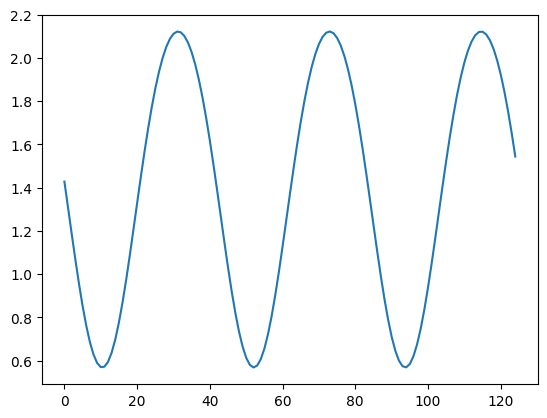

In [3]:
plt.plot(kappas, label='kappas')

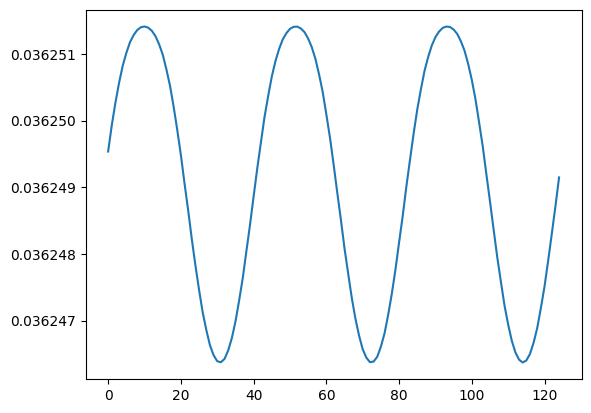

In [ ]:
plt.plot([ds(curve_copy, i) for i in range(len(curve_copy))], label='ds')
print()

Try making the integrals match!

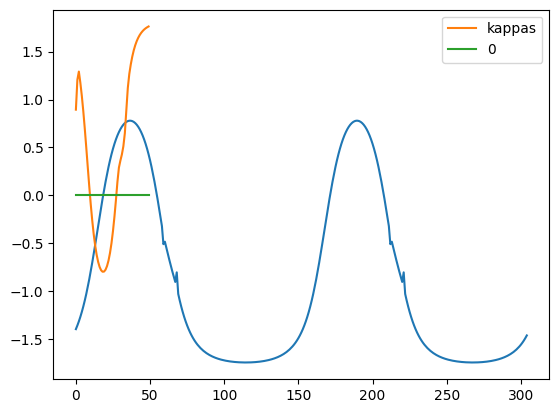

In [10]:
from helper_functions import curvature

curv = [curvature(curve, i) for i in range(len(curve))]
plt.plot(curv[1:-1])

# plt.plot(tns_clean[:30], label='tns_clean')
plt.plot(kappas[:50], label='kappas')
plt.plot(np.zeros(len(ms[:50])), label='0')
plt.legend()

### getting EOM difference for divergences

In [58]:
len(kappas_actual)
len(tns_clean)

151

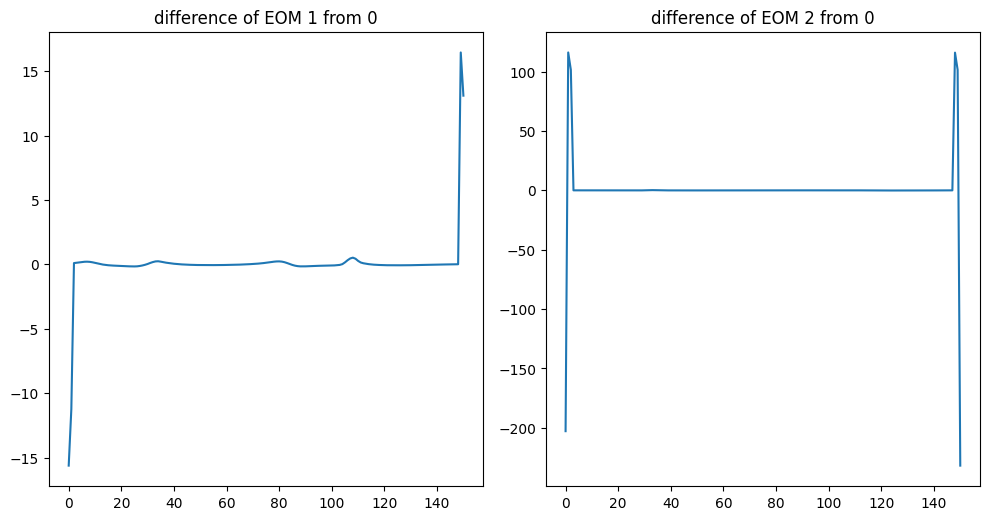

In [14]:
#now get EOM diff
delta_s = L / N

# sigmas_clean += hom1
# tns_clean += hom2

kappas_actual = dps(psis[:-1], psis=True) / delta_s # :-1 because the fwd gives a closing curve which doesn't work with out periodic derivative
# kappas_actual = np.insert(kappas_actual, 0, kappas_actual[0])
kappas_actual[-1] = kappas_actual[0]
kappas_actual = interpolate_seq_periodic(kappas_actual)(np.linspace(0, 1, N))

dtns = dps(tns_clean) / delta_s
dsigma = dps(sigmas_clean) / delta_s

d1 = dsigma + tns_clean * kappas_actual
d2 = dtns - sigmas_clean * kappas_actual + 1

plt.figure(figsize=(10, 10))

# Plot xs and ys
plt.subplot(2,2,1)
plt.plot(d1)
# plt.axis('equal')
plt.title('difference of EOM 1 from 0')

# Plot xs and ys
plt.subplot(2,2,2)
plt.plot(d2)
plt.title('difference of EOM 2 from 0')

plt.tight_layout()
plt.show()

# plt.plot(kappas_actual)

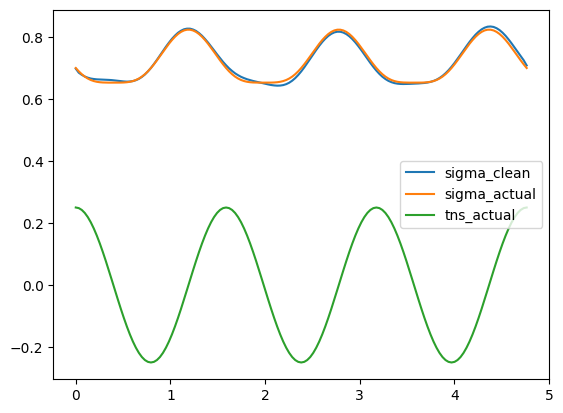

In [63]:
plt.plot(np.linspace(0, L, len(sigmas_clean)), sigmas_clean, label='sigma_clean')
plt.plot(np.linspace(0, L, len(sigmas_actual)), sigmas_actual, label='sigma_actual')
plt.plot(np.linspace(0, L, len(sigmas_actual)), tns_actual, label='tns_actual')
plt.legend()
plt.show()

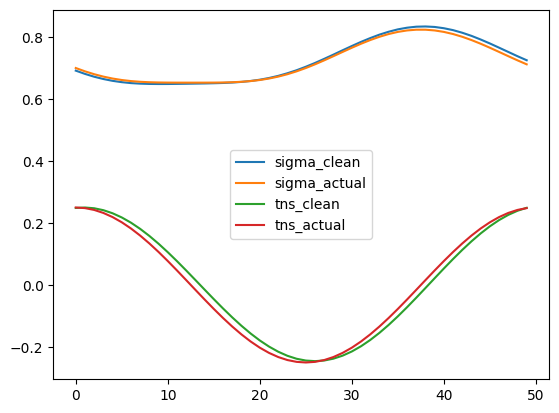

In [64]:
plt.plot(sigmas_clean[100:150], label='sigma_clean')
plt.plot(sigmas_actual[100:150], label='sigma_actual')
plt.plot(tns_clean[100:150], label='tns_clean')
plt.plot(tns_actual[100:150], label='tns_actual')
plt.legend()
plt.show()

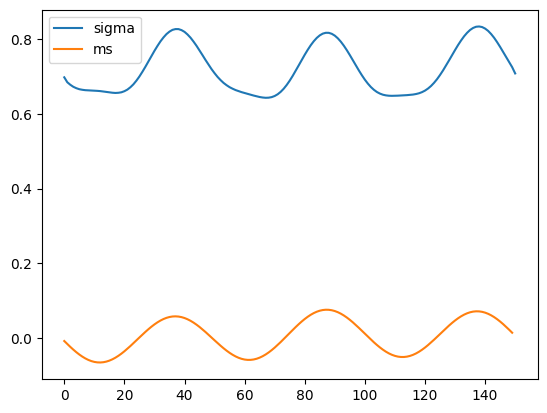

In [65]:
ms_clean = - sint.cumulative_simpson(tns_clean, dx=delta_s)

plt.plot(sigmas_clean, label='sigma')
plt.plot(ms_clean, label='ms')
plt.legend()
plt.show()

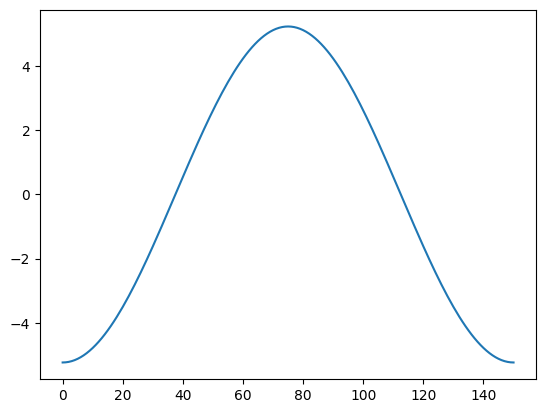

In [66]:
thetas = np.linspace(0, 2 * np.pi, len(sigmas_clean))
cos_thetas = np.cos(thetas)

y = np.cos(thetas)

a1 = 2 * sint.trapezoid(y * cos_thetas, dx=2 * np.pi / len(sigmas_clean))

plt.plot(y - a1 * cos_thetas)


In [67]:
a1

np.float64(6.2415748084565426)

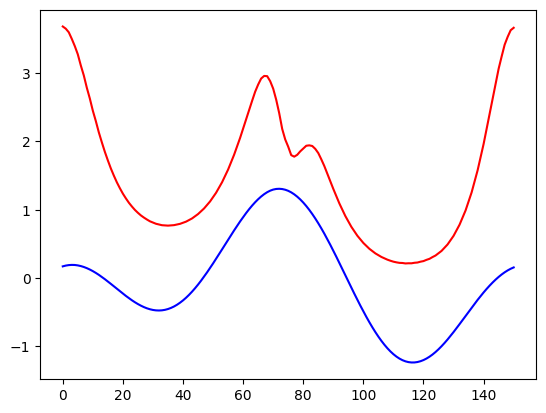

In [68]:

from helper_functions import *
import numpy as np
import matplotlib.pyplot as plt
from sets import *

N_points = 151
R = 1
thetaspan = 2 * np.pi

thetas = np.linspace(0, thetaspan * (N_points-1)/(N_points), N_points)
thetas = thetas + thetaspan / N_points / 2
xs = 2*R * np.cos(thetas)
ys = R * np.sin(thetas)
curve = np.array([xs, ys]).T

L = sum([ds(curve, i) for i in range(len(curve))])

step_theta = L / N_points

#vdisps = np.vstack((gen_cont_disps(curve, L, prec=1e-4), gen_cont_disps(curve, L, prec=1e-4)))
vdisps = np.zeros((2 * N_points, 2))

multiplier = 0
first_disps = gen_cont_disps(curve, L, prec=1e-4)
# temp = first_disps[0].copy()
# first_disps -= temp
# first_disps[0] += temp * multiplier
vdisps[0:N_points] = first_disps

second_disps = gen_cont_disps(curve, L, prec=1e-4)
# temp = second_disps[0].copy()
# second_disps -= temp
# second_disps[0] += temp * multiplier
vdisps[N_points:] = second_disps

p = 1
forces_perp = unit_normals(curve) * p

A = populate_matrix(curve, step_theta, vdisps)
b = populate_rhs(curve, forces_perp, vdisps)

soln = np.linalg.solve(A, b)

sigmas = soln[0::2]
ms = soln[1::2]

plt.plot(sigmas, label='sigma', color='red')
plt.plot(ms, label='m', color='blue')

4.540065448573096 -2.1543687777343363 -2.3396149463145948 1.96346246953341


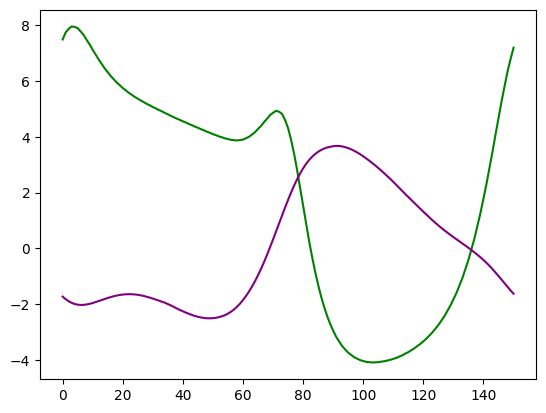

In [69]:
import numpy as np
import scipy.integrate as sint

def remove_zero_mode(soln, curve, L):
    sigmas = soln[0::2]
    ms = soln[1::2]
    tns = -dps(ms) * (len(curve) / L)
    psis = get_tgt_angles(curve)
    cos_psis = np.cos(psis)
    sin_psis = np.sin(psis)

    a1 = 2 * sint.trapezoid(cos_psis * sigmas, dx=L/len(curve))
    a2 = 2 * sint.trapezoid(sin_psis * sigmas, dx=L/len(curve))
    a3 = 2 * sint.trapezoid(cos_psis * tns, dx=L/len(curve))
    a4 = 2 * sint.trapezoid(sin_psis * tns, dx=L/len(curve))

    sigmas_bar = sigmas - (a1 * cos_psis + a2 * sin_psis)
    tns_bar = tns - (a3 * cos_psis + a4 * sin_psis)

    print(a1, a2, a3, a4)

    return sigmas_bar, tns_bar

vdisps = np.zeros((2 * N_points, 2))
first_disps = gen_cont_disps(curve, L, prec=1e-4)
vdisps[0:N_points] = first_disps
second_disps = gen_cont_disps(curve, L, prec=1e-4)
vdisps[N_points:] = second_disps

p = 1
forces_perp = unit_normals(curve) * p

A = populate_matrix(curve, step_theta, vdisps)
b = populate_rhs(curve, forces_perp, vdisps)

soln = np.linalg.solve(A, b)

sigmas, tns = remove_zero_mode(soln, curve, L)

plt.plot(sigmas, label='sigma', color='green')
plt.plot(tns, label='tn', color='purple')

Some results here:

Somehow! Changing around the displacements as in A1 B1 A2 B2 ... (correct) to A1 A2...B1B2 doesn't only work, but it is better?? TF
Subtracting the first displacement from the subsequent ones does not further regularise
Adding more points somehow also does not regularise


## Ok now let's remove some noise from here

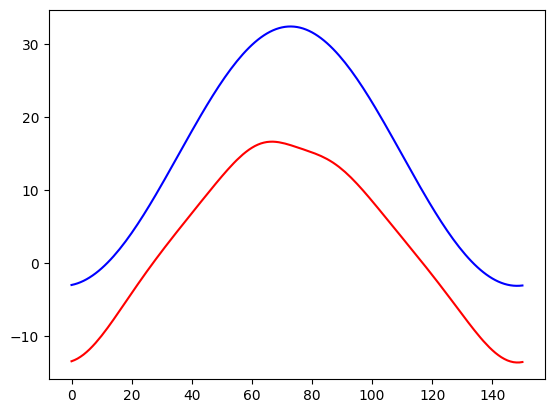

In [70]:

from helper_functions import *
import numpy as np
import matplotlib.pyplot as plt
from sets import *

N_points = 151
R = 1
thetaspan = 2 * np.pi
L = 2 * np.pi * R

thetas = np.linspace(0, thetaspan * (N_points-1)/(N_points), N_points)
thetas = thetas + thetaspan / N_points / 2
xs = 1.2*R * np.cos(thetas)
ys = R * np.sin(thetas)
curve = np.array([xs, ys]).T

# #Ok time to plate. Make sure forces are in perp direction, populate forces in the same way
step = 2 * np.pi * R / N_points
step_theta = 2 * np.pi / N_points
epsilon = step * 1e-7
vdisps = np.random.rand(2 * len(curve), 2) - 0.5
#CHANGE 1: NORMALIZING THE DISPLACEMENTS: no problem (even more regular it seems)
vdisps = vdisps / np.linalg.norm(vdisps, axis=1)[:, None]
vdisps = vdisps * epsilon

p = 1
forces_perp = unit_normals(curve) * p

A = populate_matrix(curve, step_theta, vdisps)
b = populate_rhs(curve, forces_perp, vdisps)

soln = np.linalg.solve(A, b)

sigmas = soln[0::2]
ms = soln[1::2]

plt.plot(sigmas, label='sigma', color='red')
plt.plot(ms, label='m', color='blue')

In [71]:
R = (10.7 ** 2 + 8.5 ** 2) / (12.7 ** 2 + 8.5 ** 2)
alpha = 8.5 * 7.2 * 20 / 3
eal = np.exp(-alpha * 1e-2)

(1-R) ** 2 * eal / (1-(R * eal) ** 2)

np.float64(0.00067908955749146)

In [72]:
hbar = 1.0545718e-34
epsilon_0 = 8.854187817e-12
e = 1.60217662e-19
eV = 1.60217662e-19 #in joules

mu = 800 * (2 * np.pi * hbar) ** 2 * epsilon_0 / e ** 2
mu

1.211518308333781e-37

In [73]:
c = 3e8
E = 0.007 * e / (c ** 2)
(100 * E * 2 * 137 ** 2) / (9.11e-31)

0.05134742550688133

In [74]:
(3 * hbar ** 2 * np.pi ** 2 / (2 * mh * 9.11e-31 * 0.019 * e)) ** 0.5

NameError: name 'mh' is not defined

In [ ]:
2 * 19/3

12.666666666666666

In [ ]:
mh = 0.07 * 0.45 / (0.07 + 0.45)
ml = 0.07 * 0.085 / (0.07 + 0.085)

(mh / ml) * 0.019 / 3

0.009994343891402717

In [102]:
Refl = 0.25
eps_inf = ((1+np.sqrt(Refl))/(1-np.sqrt(Refl))) ** 0.5
eps_inf

np.float64(1.7320508075688772)

In [98]:
e

1.60217662e-19

In [100]:
from scipy.optimize import curve_fit

Ns = 1e24 * np.array([0.35, 0.62, 1.2, 2.8, 4])
omegas = (e)*(1 / hbar) * np.array([0.038, 0.046, 0.056, 0.078, 0.09])

def f(N, omega):
    return e ** 2 * N / (epsilon_0*(eps_inf-1) * omega ** 2)

for N, omega in zip(Ns, omegas):
    print(f(N, omega))

3.5821655613616105e-31
4.3303283604858524e-31
5.655226389146682e-31
6.801639803558402e-31
7.2982674717547325e-31


In [99]:
omegas

array([5.77321635e+13, 6.98863032e+13, 8.50789778e+13, 1.18502862e+14,
       1.36734071e+14])

In [86]:
omegas

array([3.60335825e+32, 4.36195999e+32, 5.31021216e+32, 7.39636694e+32,
       8.53426955e+32])

In [103]:
mol = 6.022e23

m1 = 27e-3 / mol
m2 = 122e-3 / mol

9.5e12 ** 2 * (1/m1 + 1/m2)

2.4583891772920467e+51